# SYS 611: SimPy Inventory System

Paul T. Grogan <pgrogan@stevens.edu>

This example creates an inventory system simulation in SimPy.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

Final balance: 35444.29


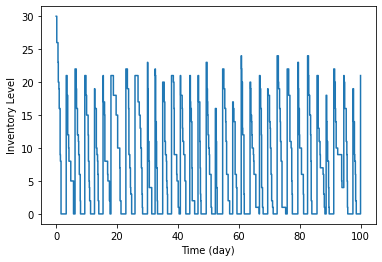

In [2]:
def warehouse_run(env, order_threshold, order_up_to):
    """ Process to run this simulation. 
    
    Args:
        env (simpy.Environment): the simulation environment
        order_threshold (int): the threshold inventory level to place order
        order_up_to (int): the target inventory level
    """
    # define global variables for inter-process communication
    # note: this is a bad practice; however, is OK in this small script
    global inventory, balance, num_ordered
    
    # initialize the state variables
    inventory = order_up_to
    balance = 0
    num_ordered = 0
    
    while True:
        # wait for the next arrival
        interarrival = np.random.exponential(1/5)
        yield env.timeout(interarrival)
        # subtract holding costs
        balance -= 2.00*inventory*interarrival
        # generate demand
        demand = np.random.randint(1, 4+1) 
        # handle demands
        if inventory > demand:
            num_sold = demand
        else:
            num_sold = inventory
        balance += 100.00*num_sold
        inventory -= num_sold
        
        # check for order
        if inventory < order_threshold and num_ordered == 0:
            quantity = order_up_to - inventory
            env.process(handle_order(env, quantity))

def handle_order(env, quantity):
    """ Process to place an order.
    
    Args:
        env (simpy.Environment): the simulation environment
        quantity (int): the order quantity
    """
    # define global variables to allow modification
    # note: this is a bad practice; however, is OK in this small script
    global inventory, balance, num_ordered
    
    num_ordered = quantity
    balance -= 50.00*quantity
    
    # wait for the delivery to arrive
    yield env.timeout(2)
    
    inventory += quantity
    num_ordered = 0

def observe(env):
    """ Process to observe the warehouse inventory during a simulation.
    
    Args:
        env (simpy.Environment): the simulation environment
        warehouse (Warehouse): the warehouse
    """
    while True:
        # record the observation time and queue length
        obs_time.append(env.now)
        obs_inventory.append(inventory)
        # wait for the next 0.1 days
        yield env.timeout(0.1)

# create the simulation environment
env = simpy.Environment()

# create arrays to record data
obs_time = []
obs_inventory = []

# add the warehouse run process
env.process(warehouse_run(env, 10, 30))
# add the observation process
env.process(observe(env))
# run the simulation for 100 days
env.run(until=100)

print('Final balance: {:.2f}'.format(balance))

# plot the inventory over time
plt.figure()
plt.step(obs_time, obs_inventory, where='post')
plt.xlabel('Time (day)')
plt.ylabel('Inventory Level')
plt.show()

## Monte Carlo Simulation

To run a Monte Carlo simulation, all of the processes can be reused from the single simulation case.

In [3]:
NUM_RUNS = 10
# threshold inventory level to trigger an order (Q)
ORDER_THRESHOLD = 10
# inventory level to order up to (S)
ORDER_UP_TO = 30

# array to store outputs
BALANCE = []

for i in range(NUM_RUNS):
    # set the initial seed
    np.random.seed(i)
    
    # create the simulation environment
    env = simpy.Environment()

    # create arrays to record data
    obs_time = []
    obs_inventory = []

    # create the servers resource
    servers = simpy.Resource(env, capacity=1)

    # add the warehouse run process
    env.process(warehouse_run(env, ORDER_THRESHOLD, ORDER_UP_TO))
    # add the observation process
    env.process(observe(env))
    # run the simulation
    env.run(until=100)
    
    # record the final observed net revenue
    BALANCE.append(balance)

# print final results to console
print('Net revenue balance for N={:} runs with Q={:} and S={:}:'.format(
        NUM_RUNS, ORDER_THRESHOLD, ORDER_UP_TO))
print('\n'.join('{:.2f}'.format(i) for i in BALANCE))

# write results to CSV file
import csv

with open('inventory.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Final Balance'])
    for i, sample in enumerate(BALANCE):
        writer.writerow([i+1, sample])

Net revenue balance for N=10 runs with Q=10 and S=30:
33168.09
34697.14
35403.40
35246.47
33849.07
32932.41
33929.40
36137.91
35661.28
34766.71
